<a href="https://colab.research.google.com/github/jsedoc/empathy_dictionary/blob/shap-lexica-creation/Learning_Word_Ratings_for_Empathy_from_Document_Level_User_Responses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code is meant as a starting point for getting word-level ratings from document-level ratings


##We start be importing packages and loading the data

In [ ]:
%matplotlib inline
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import inspect

from nltk import word_tokenize
import nltk
nltk.download('punkt')

In [ ]:
!git clone https://github.com/wwbp/empathic_reactions
sys.path.insert(1, "empathic_reactions")

In [ ]:
# NOTE: variables ending in df are pandas dataframes
empathic_reactions_df = pd.read_csv('empathic_reactions/data/responses/data/messages.csv')

In [ ]:
empathic_reactions_df

###Histograms of ratings

In [ ]:
xlabel='Ratings'
ylabel='Counts'
bins=None

In [ ]:
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Histogram of Empathy Ratings')
plt.hist(empathic_reactions_df['empathy'], bins=bins);

In [ ]:
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Histogram of Distress Ratings')
plt.hist(empathic_reactions_df['distress'], bins=bins);

###Quick Analysis of the essays

In [ ]:
# NOTE: I'm being a bit unnecessarily fancy here. I'm applying the NLTK
# NOTE: word tokenizer to the column essay 
tokenized_essays = empathic_reactions_df['essay'].apply(word_tokenize)
word_count = sum(tokenized_essays.str.len())
print(f'Total number of words in the corpus is {word_count}.')

xlabel = 'Essay Length'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Histogram of Essay Lengths')
plt.hist(tokenized_essays.str.len(), bins=bins);

###Next we'll get the word embeddings

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

In [10]:
from modeling.embedding import Embedding

print(inspect.getsource(Embedding.from_fasttext_vec))

embs = Embedding.from_fasttext_vec(
    path='./crawl-300d-2M.vec.zip',
    zipped=True,
    file='crawl-300d-2M.vec')

    @classmethod
    def from_fasttext_vec(  cls, 
                            path,
                            zipped=False,
                            file=None, 
                            vocab_limit=None, 
                            normalize=False):
        '''
        Method to read the plain text format of fasttext (usually ending with
        .vec).

        First line consists of <vocab_size><blank><dimensions>.
        '''
        if zipped==True and file is None:
            raise ValueError('You are trying to load a file withing a ZIP '+\
                'but have not indicated the name of this file.')
        
        #vectors=[]
        wi={}
        iw=[]
        m=None

        if not zipped:
            with io.open(path,'r', encoding='utf8') as f:
                # for line in f.readlines(vocab_limit+1)[1:]:
                #   count+=1
                
                first_line=f.readline().split() 
                vocab_size=int(first_line[0])
                

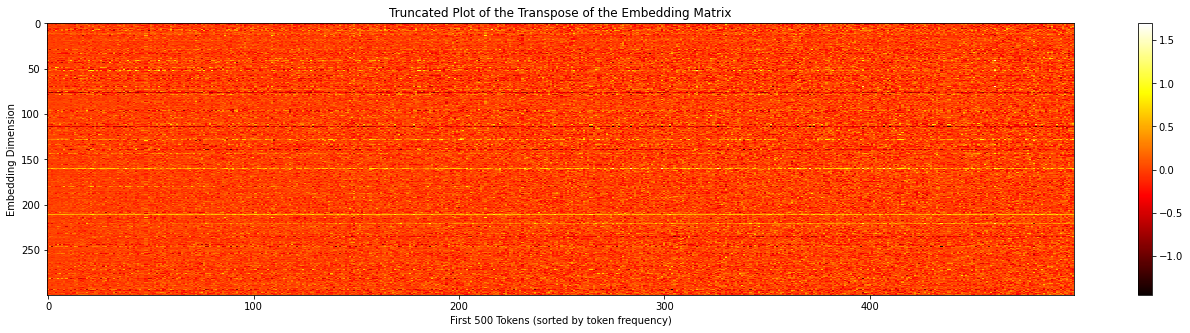

In [11]:
image_width=23
image_height=5
plt.figure(figsize=(image_width,image_height))
plt.imshow(np.transpose(embs.m[0:500]),
           cmap="hot", interpolation='nearest', aspect='auto')
plt.title('Truncated Plot of the Transpose of the Embedding Matrix')
plt.xlabel('First 500 Tokens (sorted by token frequency)')
plt.ylabel('Embedding Dimension')
plt.colorbar()

##Now we start to setup the model finally

In [12]:
import modeling.feature_extraction as fe
TIMESTEPS=200

print(inspect.getsource(fe.embedding_matrix))
FEATURES_MATRIX=fe.embedding_matrix(empathic_reactions_df['essay'], embs, TIMESTEPS)
print(FEATURES_MATRIX.shape)

def embedding_matrix(raw_data, embs, fixed_len):
	'''
	Expects list of strings.
	Turns a list of linguistic units (sentences, texts,...) into a 3d tensor,
	such that each unit is represented by a matrix of concatenated embeddings
	of the words in this unit.
	
	'''
	matrices = []
	for sent in raw_data:
		sent=[str.lower() for str in tokenize(sent)]
		# print(sent)
		features=[embs.represent(str) for str in sent]
		# now pads the left margin
		zeros=np.zeros((fixed_len, embs.dim))
		i=1
		while i <= fixed_len and i <= len(features):
			zeros[-i,:]=features[-i]
			i+=1


		# features=np.stack(features, axis=0)
		# # print(features)
		# # print(features.shape)
		# features=__pad_array__(features, fixed_len)
		# print(zeros)

		matrices.append(zeros)
	return np.stack(matrices, axis=0)

(1860, 200, 300)


In [ ]:
# NOTE this is from modeling.feature_extraction.get_cnn
# https://github.com/wwbp/empathic_reactions/blob/master/modeling/common.py#L126
# but we need tf.keras instead of keras for the new SHAP
# so I've copied and pasted here.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Concatenate, Conv1D, MaxPool1D, Reshape, Flatten, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def get_cnn(input_shape, num_outputs, num_filters, learning_rate, dropout_conv, problem):
	
	if problem not in ['regression', 'classification']:
		raise ValueError
	
	# loosely based on https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py

	# filter_sizes=[3,4,5]
	embedding_dim=input_shape[1]
	sequence_length=input_shape[0]

	

	l2_strength=.001

	inputs = Input(shape=input_shape)
	inputs_drop = Dropout(dropout_conv)(inputs)

	filter_size=1
	conv_1=Conv1D(filters=num_filters, kernel_size=filter_size, strides=1, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(inputs_drop)
	pool_1=AveragePooling1D(pool_size=input_shape[0]-filter_size+1, strides=1)(conv_1)
	pool_drop_1=Dropout(dropout_conv)(pool_1)

	filter_size=2
	conv_2=Conv1D(filters=num_filters, kernel_size=filter_size, strides=1, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(inputs_drop)
	pool_2=AveragePooling1D(pool_size=input_shape[0]-filter_size+1, strides=1)(conv_2)
	pool_drop_2=Dropout(dropout_conv)(pool_2)
	
	filter_size=3
	conv_3=Conv1D(filters=num_filters, kernel_size=filter_size, strides=1, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(inputs_drop)
	pool_3=AveragePooling1D(pool_size=input_shape[0]-filter_size+1, strides=1)(conv_3)
	pool_drop_3=Dropout(dropout_conv)(pool_3)

	concatenated=Concatenate(axis=1)([pool_drop_1, pool_drop_2, pool_drop_3])

	dense = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(l2_strength))(Flatten()(concatenated))
	dense_drop = Dropout(.5)(dense)
	
	if problem=='classification':
		output = Dense(units=num_outputs, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_strength))(dense_drop)
	if problem=='regression':
		output = Dense(units=num_outputs, activation=None, kernel_regularizer=regularizers.l2(l2_strength))(dense_drop)
	# this creates a model that includes
	model = Model(inputs=inputs, outputs=output)
	optimizer=Adam(lr=learning_rate)

	if problem=='regression':
		model.compile(loss='mse', optimizer=optimizer)
	if problem=='classification':
		model.compile(loss='binary_crossentropy', optimizer=optimizer)
	return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 300)]   0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 200, 300)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 100)     30100       dropout[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 199, 100)     60100       dropout[0][0]                    
______________________________________________________________________________________________

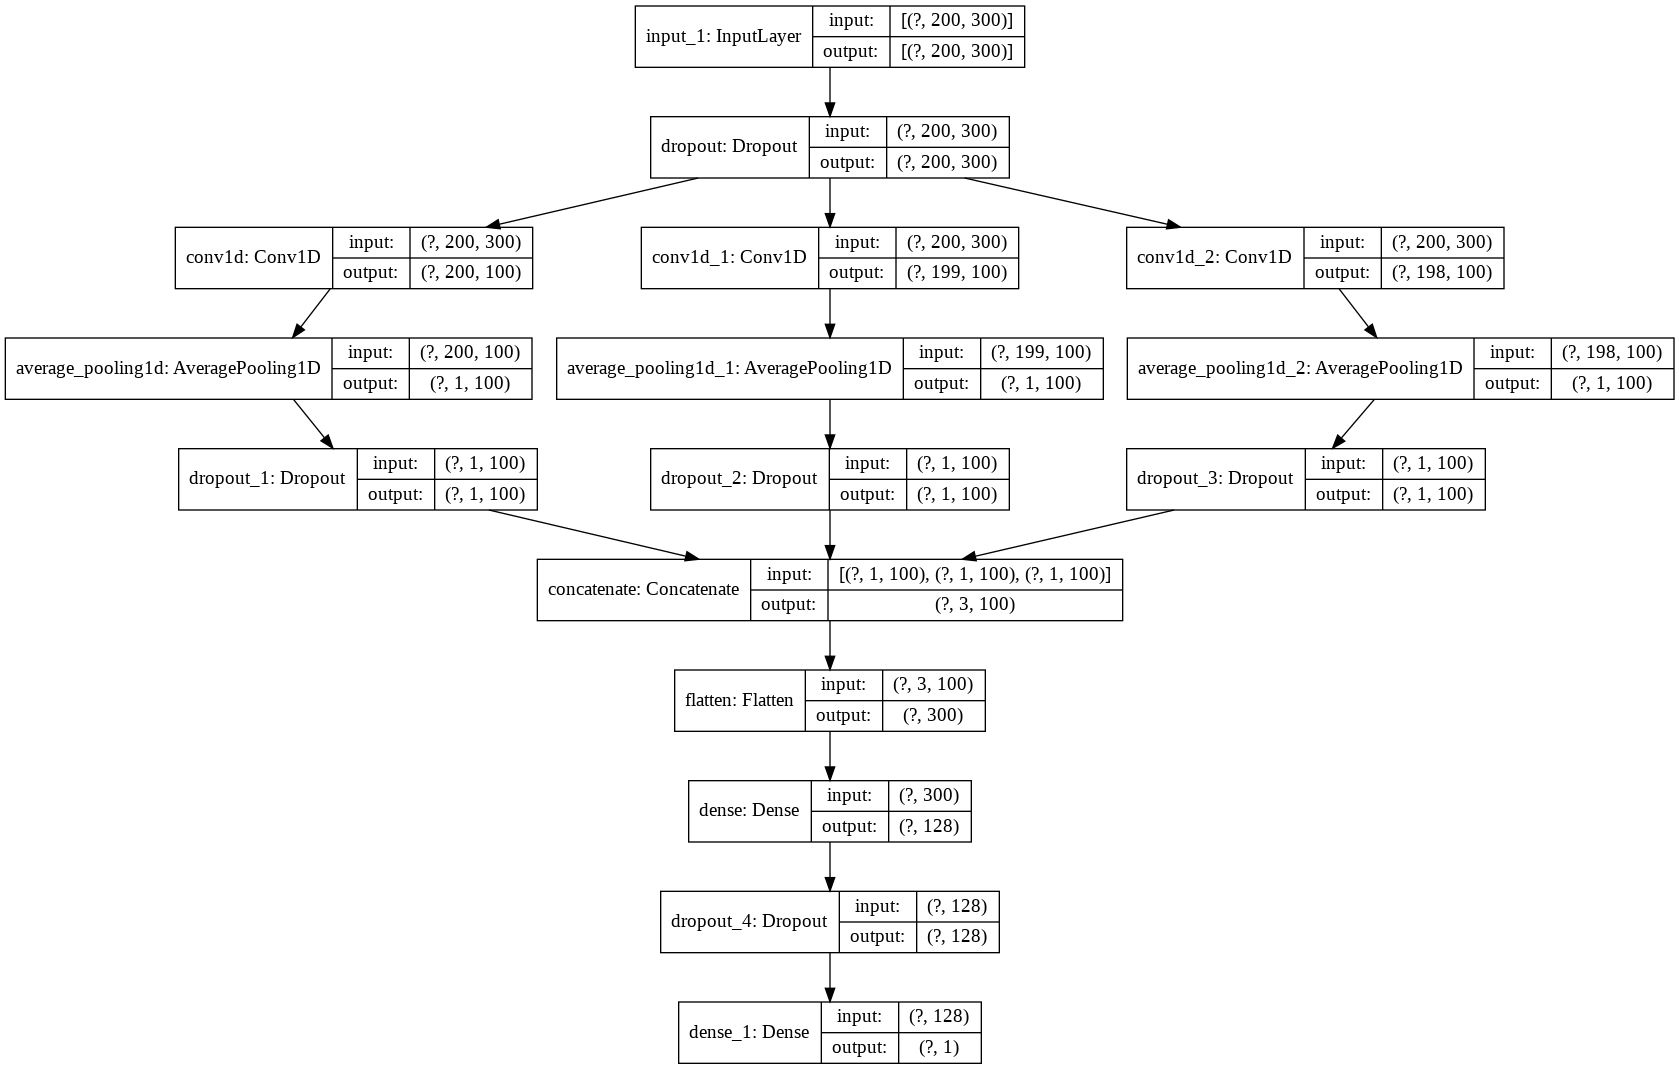

In [14]:
model = get_cnn(
					input_shape=[TIMESTEPS,300], 
					num_outputs=1, 
					num_filters=100, 
					learning_rate=1e-3,
					dropout_conv=.5, 
					problem='regression')

print(model.summary())

# Plot model graph
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

##Now we've for the Empathic Reactions Dataset ready. Next step is to train a model to predict empathy (a.k.a. empathic concern) and distress (a.k.a. personal distress)

In [15]:
from time import time
start = time()
model.fit(FEATURES_MATRIX, 
		  empathic_reactions_df['empathy'],
		  epochs=50,
		  batch_size=32, 
		  validation_split=.1)
print(f'Seconds: {time()-start}')

Epoch 1/50
53/53 [==============================] - 2s 30ms/step - loss: 6.0357 - val_loss: 4.3104
Epoch 2/50
53/53 [==============================] - 1s 20ms/step - loss: 4.2784 - val_loss: 3.9661
Epoch 3/50
53/53 [==============================] - 1s 20ms/step - loss: 4.1073 - val_loss: 3.6970
Epoch 4/50
53/53 [==============================] - 1s 20ms/step - loss: 3.6645 - val_loss: 3.5474
Epoch 5/50
53/53 [==============================] - 1s 20ms/step - loss: 3.5882 - val_loss: 3.4874
Epoch 6/50
53/53 [==============================] - 1s 20ms/step - loss: 3.6347 - val_loss: 3.3546
Epoch 7/50
53/53 [==============================] - 1s 20ms/step - loss: 3.3881 - val_loss: 3.2987
Epoch 8/50
53/53 [==============================] - 1s 20ms/step - loss: 3.4000 - val_loss: 3.4223
Epoch 9/50
53/53 [==============================] - 1s 20ms/step - loss: 3.5087 - val_loss: 3.2084
Epoch 10/50
53/53 [==============================] - 1s 20ms/step - loss: 3.3328 - val_loss: 3.1983
Epoch 11/

##Now at long last we run SHAP DeepExplainer
**WARNING: This code is only meant as a starting point!**

In [16]:
!pip install shap
import shap

     |████████████████████████████████| 276kB 6.3MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394111 sha256=d4f7fba5cdc9a87be8773a3e19145cf83f9811481dde0e15fa7b8f76638cee03
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [17]:
explainer = shap.DeepExplainer(model, FEATURES_MATRIX[:200])

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [ ]:
word_idx_matrix = np.zeros((empathic_reactions_df['essay'].shape[0], TIMESTEPS), dtype=int)
tokenized_essays = empathic_reactions_df['essay'].apply(word_tokenize)
for i, sent in enumerate(tokenized_essays):
    sent=[str.lower() for str in sent]
    word_idx_matrix[i][TIMESTEPS-len(sent):TIMESTEPS] = [embs.wi.get(_, 0) for _ in sent]


In [19]:
from time import time
start = time()
shap_values = explainer.shap_values(FEATURES_MATRIX)
print(f'Seconds: {time()-start}')

Seconds: 580.4133496284485


In [20]:
word2values={}
shap_means = shap_values[0].mean(axis=2)
for i in range(FEATURES_MATRIX.shape[0]):
    for j in range(FEATURES_MATRIX.shape[1]):
        if word_idx_matrix[i][j] == 0:
            continue
        if embs.iw[word_idx_matrix[i][j]] not in word2values: 
            word2values[embs.iw[word_idx_matrix[i][j]]] = []
        word2values[embs.iw[word_idx_matrix[i][j]]].append(shap_means[i][j])

lexicon = {'words':[], 'values':[]}
min_word = ''
max_word = ''
min = 100
max = -100
for word in word2values:
    lexicon['words'].append(word)
    lexicon['values'].append(np.mean(word2values[word]))
    #print(word, np.mean(word2value[word]))
    if np.mean(word2values[word]) < min:
        min = np.mean(word2values[word])
        min_word = word
    if np.mean(word2values[word]) > max:
        max = np.mean(word2values[word])
        max_word=word

print(min_word, min)
print(max_word, max)

lexicon_df = pd.DataFrame.from_dict(lexicon)
lexicon_df.sort_values(by='values')

vapid -0.0007708038526875112
grieving 0.0011175501890102082


,words,values
3309,vapid,-0.000771
7021,pissy,-0.000560
8596,pipedreams,-0.000545
9141,snobby,-0.000539
6527,idiotic,-0.000533
...,...,...
97,duckworth,0.000913
7708,garcía,0.000930
1406,lukemia,0.000958
2555,orphaned,0.001074
